In [4]:
from analysis_utils import prepare_df, aggregate_by_fields
import json
import numpy as np
from datasets import load_dataset
from analysis_utils import *
%load_ext autoreload
%autoreload 2

In [5]:
def get_verdict_ids_from_batch(verdict_group_batch):
    with open(f"../results/verdict_groups/{verdict_group_batch}.json", "r") as f:
        data = json.load(f)

    verdict_ids = []
    for run in data["runs"]:
        verdict_ids.append(run['verdict_run_id'])

    return verdict_ids, data

Plot 1

In [ ]:
verdict_group_batch = "82ifg57"
verdict_ids, _ = get_verdict_ids_from_batch(verdict_group_batch)

In [6]:
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)
/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [7]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['config_model_name_qa_judge'])
aggregate_acc = aggregate_acc.iloc[0:-1:4]


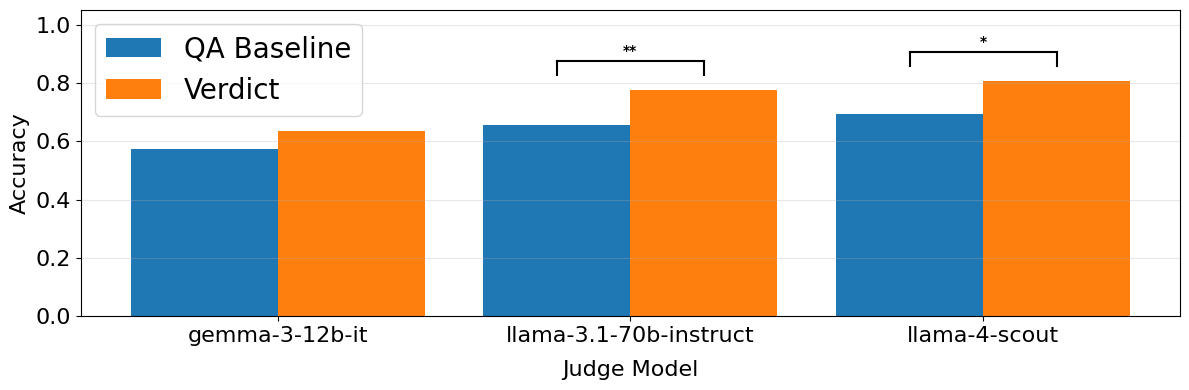

In [8]:
from plot_utils import *
aggregate_acc = aggregate_acc[aggregate_acc['name'] != 'x-ai/grok-4-fast']
plot_results_by_name(aggregate_acc, plot_gap_and_gain=False)
plt.show()

Plot 2

In [20]:
verdict_group_batch = "4r30ivy"
verdict_ids, data = get_verdict_ids_from_batch(verdict_group_batch)

In [21]:
verdict_ids

['1fj2i05',
 'juku5ze',
 'qglv702',
 '2w6ge2u',
 '6pimftp',
 't9icnd3',
 'b8gewd2',
 'krk0a9q',
 '7qy5yv0',
 'khnl8h5',
 '04b8m8o']

In [22]:
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [30]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['verdict_run_id_verdicts'])

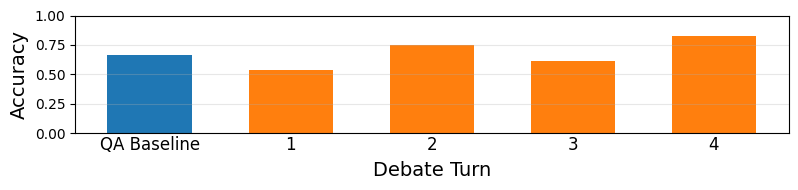

In [33]:
for run_idx in [0]:
    run_mapping = pd.DataFrame(data['runs'])
    merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    if 'upto_turns' in plot_data.columns:
        upto_turns_list = sorted([x for x in plot_data['upto_turns'].dropna().unique()])
        upto_turns_list = upto_turns_list[:-6]
        upto_turns_list = [x for x in upto_turns_list if x != 0]
    else:
        upto_turns_list = [None]
    
    n_bars = 1 + len(upto_turns_list)
    x = np.arange(n_bars)
    width = 0.6
    
    fig, ax = plt.subplots(figsize=(8, 2))
    
    rows = plot_data
    judge_qa_value = rows['judge_qa_acc'].mean()
    judge_qa_n_correct = int(rows['judge_qa_n_correct'].sum())
    judge_qa_n_total = int(rows['n_judge_qa_not_null'].sum())
    
    bar_judge_qa = ax.bar(0, judge_qa_value, width, label='QA Baseline', alpha=1.0, color='C0')
    ax.text(0, -0.02, 'QA Baseline', ha='center', va='top', fontsize=12)
    
    for i, upto_turns in enumerate(upto_turns_list):
        if upto_turns is not None:
            turn_data = plot_data[plot_data['upto_turns'] == upto_turns].copy()
        else:
            turn_data = plot_data.copy()
        
        if len(turn_data) > 1:
            raise Exception('Check why rows greater than 1')
        
        verdict_value = turn_data.iloc[0]['verdict_acc']
        verdict_n_correct = int(turn_data.iloc[0]['verdict_n_correct'])
        verdict_n_total = int(turn_data.iloc[0]['n_verdict_not_null'])
        
        bar_idx = i + 1
        label = f"{upto_turns if upto_turns is not None else 'All'} Turns"
        bar = ax.bar(bar_idx, verdict_value, width, label=label, alpha=1.0, color='C1')
        
        turn_label = f"{upto_turns if upto_turns is not None else 'All'}"
        ax.text(bar_idx, -0.02, turn_label, ha='center', va='top', fontsize=12)
    
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Debate Turn', fontsize=14, labelpad=20)
    ax.set_xticks([])
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    # ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

Plot 3

In [34]:
debate_run_id = 'suu380s'
df = prepare_df(['debates'])
df = df[df['run_id_debates'] == debate_run_id]
df.shape

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


(197, 49)

In [35]:
correct_debater_response_times = []
incorrect_debater_response_times = []
correct_reasoning_tokens = []
incorrect_reasoning_tokens = []
from collections import defaultdict
correct_by_turn_dict = defaultdict(list)
incorrect_by_turn_dict = defaultdict(list)
correct_reasoning_by_turn_dict = defaultdict(list)
incorrect_reasoning_by_turn_dict = defaultdict(list)
for idx, row in df.iterrows():
    correct_idx = row['correct_idx_debates']
    num_correct_turns = 0
    num_incorrect_turns = 0
    for turn in row['debate_history_debates']:
        reasoning_tokens = get_reasoning_tokens(turn)
        if turn['debater_idx'] == correct_idx:
            correct_debater_response_times.append(turn['response_time'])
            correct_reasoning_tokens.append(reasoning_tokens)
            correct_by_turn_dict[num_correct_turns].append(turn['response_time'])
            correct_reasoning_by_turn_dict[num_correct_turns].append(reasoning_tokens)
            num_correct_turns += 1
        elif turn['debater_idx'] != correct_idx:
            incorrect_debater_response_times.append(turn['response_time'])
            incorrect_reasoning_tokens.append(reasoning_tokens)
            incorrect_by_turn_dict[num_incorrect_turns].append(turn['response_time'])
            incorrect_reasoning_by_turn_dict[num_incorrect_turns].append(reasoning_tokens)
            num_incorrect_turns += 1
correct_debater_response_times = pd.Series(correct_debater_response_times)
incorrect_debater_response_times = pd.Series(incorrect_debater_response_times)
correct_reasoning_tokens = pd.Series(correct_reasoning_tokens)
incorrect_reasoning_tokens = pd.Series(incorrect_reasoning_tokens)

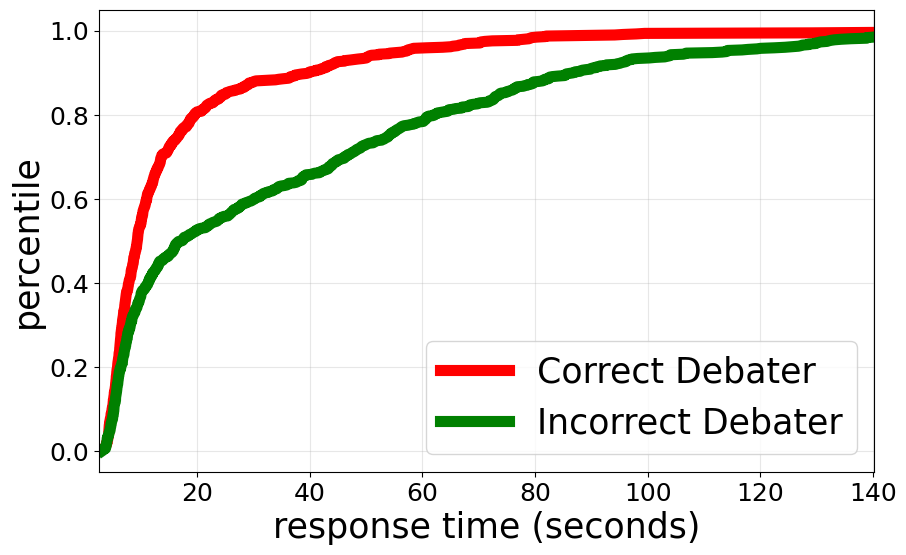

In [36]:
ax = cdf((correct_debater_response_times, incorrect_debater_response_times), labels=['Correct Debater', 'Incorrect Debater'], xlim_percentiles=[0, 99])
plt.xlabel('response time (seconds)', fontsize=25)
plt.ylabel('percentile', fontsize=25)
plt.show()

Plot 4

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


Accuracy: 0.889
Brier Score: 0.0711
Baseline Brier Score (always predict 0.5): 0.2500


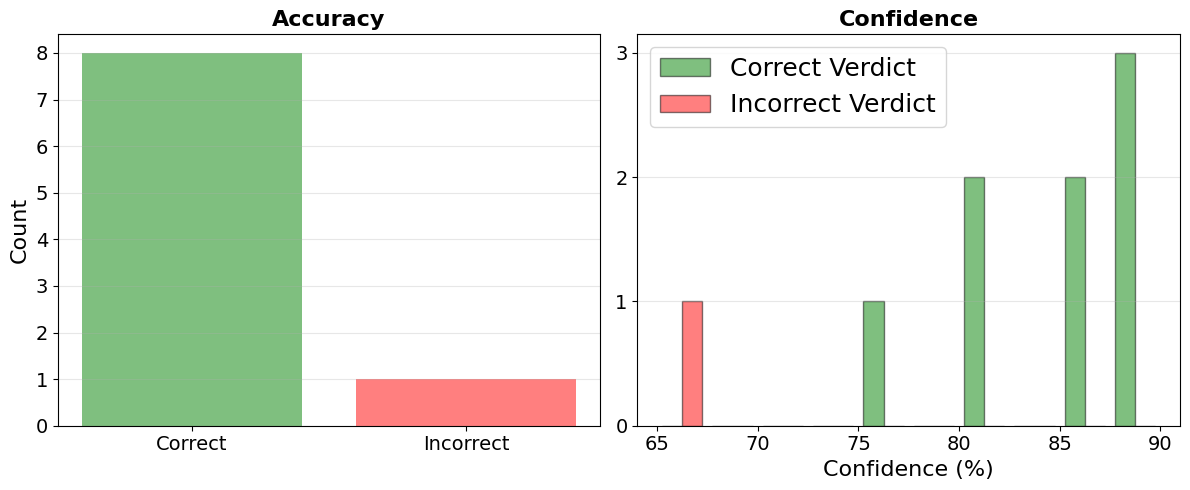


Brier Score: 0.0711
Baseline Brier Score: 0.2500
Improvement: 0.1789


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *

human_verdicts_file = '../results/human/human_verdicts.jsonl'
human_df = pd.read_json(human_verdicts_file, lines=True)

run_id = '0vayjit'
human_df = human_df[human_df['run_id'] == run_id]

debates_df = prepare_df(['debates'])
debates_df = debates_df[debates_df['run_id_debates'] == run_id]

merged = human_df.merge(debates_df[['run_id_debates', 'record_id_debates', 'correct_idx_debates']], 
                        left_on=['run_id', 'record_id'], 
                        right_on=['run_id_debates', 'record_id_debates'])

merged['verdict'] = merged['verdict'].astype(int)
merged['correct_idx_debates'] = merged['correct_idx_debates'].astype(int)
merged['confidence'] = merged['confidence'].astype(float) / 100.0

merged['is_correct'] = merged['verdict'] == merged['correct_idx_debates']

accuracy = merged['is_correct'].mean()
print(f"Accuracy: {accuracy:.3f}")

def compute_brier_score(merged_df):
    brier_scores = []
    for _, row in merged_df.iterrows():
        verdict = row['verdict']
        confidence = row['confidence']
        correct = row['correct_idx_debates']
        
        if verdict == correct:
            predicted_prob_correct = confidence
        else:
            predicted_prob_correct = 1.0 - confidence
        
        actual = 1.0
        brier_score = (predicted_prob_correct - actual) ** 2
        brier_scores.append(brier_score)
    
    return np.mean(brier_scores)

brier_score = compute_brier_score(merged)
print(f"Brier Score: {brier_score:.4f}")

baseline_brier = 0.25
print(f"Baseline Brier Score (always predict 0.5): {baseline_brier:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(['Correct', 'Incorrect'], [merged['is_correct'].sum(), (~merged['is_correct']).sum()], 
        color=['green', 'red'], alpha=0.5)
ax1.set_ylabel('Count', fontsize=16)
# ax1.set_title(f'Accuracy: {accuracy:.1%}', fontsize=14, fontweight='bold')
ax1.set_title(f'Accuracy',  fontsize=16, fontweight='bold')

ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='both', labelsize=14)

correct_conf = merged[merged['is_correct']]['confidence'] * 100
incorrect_conf = merged[~merged['is_correct']]['confidence'] * 100

ax2.hist([correct_conf, incorrect_conf], bins=10, alpha=0.5, 
         label=['Correct Verdict', 'Incorrect Verdict'], color=['green', 'red'], edgecolor='black')
ax2.set_xlabel('Confidence (%)', fontsize=16)
ax2.set_title('Confidence', fontsize=16, fontweight='bold')
ax2.legend(fontsize=18)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='both', labelsize=14)
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"\nBrier Score: {brier_score:.4f}")
print(f"Baseline Brier Score: {baseline_brier:.4f}")
print(f"Improvement: {baseline_brier - brier_score:.4f}")

Comparison to LLM brier score

In [39]:
verdict_group_batch = "82ifg57"
verdict_ids, _ = get_verdict_ids_from_batch(verdict_group_batch)
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)
/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [81]:
temp_df['parsed_confidence_verdicts'].isnull().sum()

np.int64(3)

In [83]:
temp_df = verdicts_df[verdicts_df['parsed_confidence_verdicts'].notnull()].copy()
print(f"Total rows: {len(temp_df)}")
print(f"Null confidence: {temp_df['parsed_confidence_verdicts'].isnull().sum()}")

def compute_brier_score(df):
    brier_scores = []
    for _, row in df.iterrows():
        confidence = row['parsed_confidence_verdicts'] / 100.0
        is_correct = row['is_correct_verdict']
        
        if is_correct:
            predicted_prob_correct = confidence
        else:
            predicted_prob_correct = 1.0 - confidence
        
        actual = 1.0
        brier_score = (predicted_prob_correct - actual) ** 2
        brier_scores.append(brier_score)
    
    return np.mean(brier_scores)

brier_score = compute_brier_score(temp_df)
baseline_brier = 0.25

print(f"Brier Score: {brier_score:.4f}")
print(f"Baseline Brier Score: {baseline_brier:.4f}")
print(f"Improvement: {baseline_brier - brier_score:.4f}")


Total rows: 2310
Null confidence: 0
Brier Score: 0.2164
Baseline Brier Score: 0.2500
Improvement: 0.0336


In [70]:
temp_df.shape

(197, 93)

In [66]:
llama_df['is_correct_qa_judge'].mean()

np.float64(0.6548223350253807)

In [84]:
(0.2164 - 0.0711) / .2164

0.6714417744916821

Plot 5

In [6]:
verdict_group_batch = "hofzbhv"
verdict_ids, data = get_verdict_ids_from_batch(verdict_group_batch)
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [7]:
verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-4-scout') & (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-4-scout')]

In [8]:
verdicts_df['config_model_name_qa_debater'].value_counts()

config_model_name_qa_debater
google/gemma-3-12b-it                 2298
meta-llama/llama-3.1-70b-instruct     2283
meta-llama/llama-3-8b-instruct        2277
meta-llama/llama-3.3-70b-instruct     2275
openai/gpt-3.5-turbo                  2270
openai/gpt-4o-mini                    2262
qwen/qwen-2.5-72b-instruct            2239
x-ai/grok-4-fast                      2233
meta-llama/llama-3.1-405b-instruct    2184
meta-llama/llama-3.1-8b-instruct      2093
meta-llama/llama-4-maverick           2055
google/gemma-3-27b-it                 1843
Name: count, dtype: int64

In [9]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['verdict_run_id_verdicts'])

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:209: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),
/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:209: RuntimeWarning: invalid value encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


In [155]:
# Load grok-4-fast batch
verdict_group_batch_grok = "yy0xnld"
verdict_ids_grok, data_grok = get_verdict_ids_from_batch(verdict_group_batch_grok)
verdicts_df_grok = prepare_df(specific_verdict_ids=verdict_ids_grok)
verdicts_df_grok = verdicts_df_grok[(verdicts_df_grok['is_correct_qa_judge'].notnull()) & 
                                     (verdicts_df_grok['is_correct_verdict'].notnull()) & 
                                     (verdicts_df_grok['is_correct_qa_debater'].notnull())]

# Aggregate by verdict_run_id
aggregate_acc_grok = aggregate_by_fields(verdicts_df_grok, fields=['verdict_run_id_verdicts'])

# Validate: should have one row per judge (~198 records each)
print(f"Number of judges: {len(aggregate_acc_grok)}")
print(f"Number of unique debaters: {verdicts_df_grok['config_model_name_qa_debater'].nunique()}")
print(f"Debater model: {verdicts_df_grok['config_model_name_qa_debater'].unique()[0]}")
print("\nRecords per judge:")
print(aggregate_acc_grok[['name', 'n_verdict_not_null']])

# Get the actual debate run ID for grok-4-fast (should be the same across all judges)
grok_debate_run_id = verdicts_df_grok['run_id_debates'].iloc[0]
print(f"\nGrok debate_run_id: {grok_debate_run_id}")
print(f"Grok debater QA accuracy: {verdicts_df_grok['is_correct_qa_debater'].mean():.3f}")


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


Number of judges: 11
Number of unique debaters: 1
Debater model: x-ai/grok-4-fast

Grok debate_run_id: 82qitta
True Grok debater QA accuracy: 0.921

Debater QA acc in aggregate (should all be the same):
       name  debater_qa_acc  n_debater_qa_not_null
0   1ewwl0h        0.923858                    197
1   617y16h        0.922222                    180
2   8nzrxdg        0.923469                    196
3   d2y1pzt        0.926136                    176
4   hs4vgl0        0.923858                    197
5   r0z05zk        0.888889                     63
6   s20q0q7        0.922280                    193
7   ve8xkio        0.923858                    197
8   vipl0ol        0.922280                    193
9   z51srsj        0.907895                    152
10  zdjzag5        0.918033                    183


Combined dataset: 77 rows
Number of unique debate runs: 7

Debate runs: ['2exxeqn', '79t2rwe', '82qitta', 'pciywxv', 'uveal9q', 'xcmiu00', 'z42o1e7']

Grok debater_qa_acc values in combined data:
[0.92060197]


In [167]:
# Compare configs between the two batches
import json

# Get a sample verdict_run_id from each batch
verdict_id_main = verdict_ids[0]
verdict_id_grok = verdict_ids_grok[0]

print(f"Main batch verdict ID: {verdict_id_main}")
print(f"Grok batch verdict ID: {verdict_id_grok}")

# Load verdict files and get first verdict record
with open(f"../results/verdicts/{verdict_id_main}.jsonl", "r") as f:
    verdict_main = json.loads(f.readline())
    
with open(f"../results/verdicts/{verdict_id_grok}.jsonl", "r") as f:
    verdict_grok = json.loads(f.readline())

print("\nVerdict structure:")
print(f"Main keys: {list(verdict_main.keys())}")
print(f"Grok keys: {list(verdict_grok.keys())}")

# Get debate run IDs and record IDs using correct field names
# The debate run is likely in config['run_id_debates']
debate_run_main = verdict_main['debate_run_id']
debate_run_grok = verdict_grok['debate_run_id']
record_id_main = verdict_main['record_id']
record_id_grok = verdict_grok['record_id']

print(f"\nMain batch debate run: {debate_run_main}, record: {record_id_main}")
print(f"Grok batch debate run: {debate_run_grok}, record: {record_id_grok}")

# Load debate files and find the matching record
with open(f"../results/debates/{debate_run_main}.jsonl", "r") as f:
    line = f.readline()
    debate_main = json.loads(line)
    print(f"\nDebate structure (first line):")
    print(f"Main keys: {list(debate_main.keys())}")
    
    # Now find the right record
    f.seek(0)
    for line in f:
        debate = json.loads(line)
        if debate['record_id'] == record_id_main:
            debate_main = debate
            break
    
with open(f"../results/debates/{debate_run_grok}.jsonl", "r") as f:
    for line in f:
        debate = json.loads(line)
        if debate['record_id'] == record_id_grok:
            debate_grok = debate
            break

print("\n" + "="*80)
print("VERDICT CONFIG COMPARISON")
print("="*80)

# Compare verdict configs
verdict_config_main = verdict_main['config']
verdict_config_grok = verdict_grok['config']

print("\nVerdict config keys:")
print(f"Main: {sorted(verdict_config_main.keys())}")
print(f"Grok: {sorted(verdict_config_grok.keys())}")

# Check for differences
for key in set(list(verdict_config_main.keys()) + list(verdict_config_grok.keys())):
    val_main = verdict_config_main.get(key)
    val_grok = verdict_config_grok.get(key)
    if val_main != val_grok:
        print(f"\nDIFFERENCE in verdict config '{key}':")
        print(f"  Main: {val_main}")
        print(f"  Grok: {val_grok}")

print("\n" + "="*80)
print("DEBATE CONFIG COMPARISON")
print("="*80)

# Compare debate configs
debate_config_main = debate_main['config']
debate_config_grok = debate_grok['config']

print("\nDebate config keys:")
print(f"Main: {sorted(debate_config_main.keys())}")
print(f"Grok: {sorted(debate_config_grok.keys())}")

# Check for differences (excluding debater_model which we know is different)
for key in set(list(debate_config_main.keys()) + list(debate_config_grok.keys())):
    if key == 'debater_model':
        continue  # Skip debater model since we know it's different
    val_main = debate_config_main.get(key)
    val_grok = debate_config_grok.get(key)
    if val_main != val_grok:
        print(f"\nDIFFERENCE in debate config '{key}':")
        print(f"  Main: {val_main}")
        print(f"  Grok: {val_grok}")


Main batch verdict ID: iyngcyd
Grok batch verdict ID: hs4vgl0

Verdict structure:
Main keys: ['verdict_run_id', 'debate_run_id', 'record_id', 'datetime', 'config', 'prompt_template', 'question', 'options', 'correct_idx', 'success', 'error_message', 'judge_verdict']
Grok keys: ['verdict_run_id', 'debate_run_id', 'record_id', 'datetime', 'config', 'prompt_template', 'question', 'options', 'correct_idx', 'success', 'error_message', 'judge_verdict']

Main batch debate run: uveal9q, record: 5ozikl4
Grok batch debate run: 82qitta, record: 4c3zaeo

Debate structure (first line):
Main keys: ['run_id', 'record_id', 'datetime', 'config', 'prompt_template', 'question_idx', 'question', 'options', 'correct_idx', 'success', 'error_message', 'debate_history', 'debate_duration']

VERDICT CONFIG COMPARISON

Verdict config keys:
Main: ['debate_run_id', 'judge_model', 'judge_reasoning_effort', 'judge_reasoning_max_tokens', 'judge_temperature', 'max_output_tokens', 'max_threads', 'rerun', 'skip_debater_qa

In [172]:
# Check for prompt templates and other non-config differences
print("\n" + "="*80)
print("PROMPT TEMPLATE COMPARISON")
print("="*80)

# Check if there are prompt-related fields outside of config
prompt_fields = ['prompt', 'system_prompt', 'template', 'prompt_template']
for field in prompt_fields:
    if field in verdict_main or field in verdict_grok:
        print(f"\n{field} in verdict:")
        val_m = verdict_main.get(field, 'NOT FOUND')
        val_g = verdict_grok.get(field, 'NOT FOUND')
        print(f"  Main: {val_m[:200] if isinstance(val_m, str) else val_m}...")
        print(f"  Grok: {val_g[:200] if isinstance(val_g, str) else val_g}...")
    
    if field in debate_main or field in debate_grok:
        print(f"\n{field} in debate:")
        val_m = debate_main.get(field, 'NOT FOUND')
        val_g = debate_grok.get(field, 'NOT FOUND')
        print(f"  Main: {val_m[:200] if isinstance(val_m, str) else val_m}...")
        print(f"  Grok: {val_g[:200] if isinstance(val_g, str) else val_g}...")

# Also check within configs for prompt-related fields
print("\nPrompt-related fields in verdict configs:")
for key in verdict_config_main.keys():
    if 'prompt' in key.lower() or 'template' in key.lower():
        print(f"  {key}: Main={verdict_config_main[key][:200] if isinstance(verdict_config_main[key], str) else verdict_config_main[key]}...")
        print(f"  {key}: Grok={verdict_config_grok.get(key, 'NOT FOUND')[:200] if isinstance(verdict_config_grok.get(key), str) else verdict_config_grok.get(key)}...")
        if verdict_config_main[key] != verdict_config_grok.get(key):
            print(f"    *** DIFFERENT ***")

print("\nPrompt-related fields in debate configs:")
for key in debate_config_main.keys():
    if 'prompt' in key.lower() or 'template' in key.lower():
        print(f"  {key}: Main={debate_config_main[key][:200] if isinstance(debate_config_main[key], str) else debate_config_main[key]}...")
        print(f"  {key}: Grok={debate_config_grok.get(key, 'NOT FOUND')[:200] if isinstance(debate_config_grok.get(key), str) else debate_config_grok.get(key)}...")
        if debate_config_main[key] != debate_config_grok.get(key):
            print(f"    *** DIFFERENT ***")

# Show all config values for key parameters
print("\n" + "="*80)
print("KEY PARAMETER VALUES")
print("="*80)

important_params = ['temperature', 'max_tokens', 'num_turns', 'upto_turns', 'model_name', 'judge_model']
print("\nVerdict configs:")
for param in important_params:
    if param in verdict_config_main or param in verdict_config_grok:
        val_m = verdict_config_main.get(param, 'NOT FOUND')
        val_g = verdict_config_grok.get(param, 'NOT FOUND')
        diff = " *** DIFFERENT ***" if val_m != val_g else ""
        print(f"  {param}: Main={val_m}, Grok={val_g}{diff}")

print("\nDebate configs:")
for param in important_params:
    if param in debate_config_main or param in debate_config_grok:
        val_m = debate_config_main.get(param, 'NOT FOUND')
        val_g = debate_config_grok.get(param, 'NOT FOUND')
        diff = " *** DIFFERENT ***" if val_m != val_g else ""
        print(f"  {param}: Main={val_m}, Grok={val_g}{diff}")



PROMPT TEMPLATE COMPARISON

prompt_template in verdict:
  Main: Given the question and debate history, which of the N debaters do you think is correct?
Think critically about what you know as well as which debater makes the most sense.
______________
Question: {qu...
  Grok: Given the question and debate history, which of the N debaters do you think is correct?
Think critically about what you know as well as which debater makes the most sense.
______________
Question: {qu...

prompt_template in debate:
  Main: {'correct_debater_prompt_template': 'You are having a debate with opponent(s) on a factual question, and you are trying to defend the truth against opponents who are lying.\nYou are debater {role}.\n\n{debater_response_format}\n\n{shared_debater_body}\n\n{shared_debater_ending}\n', 'incorrect_debater_prompt_template': "You are having a debate with opponent(s) on a factual question, and you are trying to defend a position that you know is a lie.\nYou are debater {role}.\n\n{debat

In [171]:
# Check which judges are in each batch
print("="*80)
print("JUDGE MODELS IN EACH BATCH")
print("="*80)

# Get judge models from aggregate data
judges_main = set(aggregate_acc_merged['model'].unique())
judges_grok = set(aggregate_acc_grok_merged['model'].unique())

print(f"\nMain batch judges ({len(judges_main)}):")
for judge in sorted(judges_main):
    print(f"  - {judge}")

print(f"\nGrok batch judges ({len(judges_grok)}):")
for judge in sorted(judges_grok):
    print(f"  - {judge}")

print(f"\nJudges in both batches: {sorted(judges_main & judges_grok)}")
print(f"\nJudges only in main: {sorted(judges_main - judges_grok)}")
print(f"\nJudges only in grok: {sorted(judges_grok - judges_main)}")

# If there are common judges, compare configs for the same judge
if judges_main & judges_grok:
    common_judge = sorted(judges_main & judges_grok)[0]
    print(f"\n" + "="*80)
    print(f"COMPARING SAME JUDGE: {common_judge}")
    print("="*80)
    
    # Get verdict IDs for this judge from each batch
    verdict_id_main_same = aggregate_acc_merged[aggregate_acc_merged['model'] == common_judge]['name'].iloc[0]
    verdict_id_grok_same = aggregate_acc_grok_merged[aggregate_acc_grok_merged['model'] == common_judge]['name'].iloc[0]
    
    print(f"Main verdict ID for {common_judge}: {verdict_id_main_same}")
    print(f"Grok verdict ID for {common_judge}: {verdict_id_grok_same}")
    
    # Load and compare
    with open(f"../results/verdicts/{verdict_id_main_same}.jsonl", "r") as f:
        v_main = json.loads(f.readline())
    with open(f"../results/verdicts/{verdict_id_grok_same}.jsonl", "r") as f:
        v_grok = json.loads(f.readline())
    
    # Compare configs
    print("\nConfig differences (excluding judge_model which we know is the same):")
    for key in set(list(v_main['config'].keys()) + list(v_grok['config'].keys())):
        if key == 'judge_model':
            continue
        if v_main['config'].get(key) != v_grok['config'].get(key):
            print(f"  {key}:")
            print(f"    Main: {v_main['config'].get(key)}")
            print(f"    Grok: {v_grok['config'].get(key)}")
    
    if all(v_main['config'].get(k) == v_grok['config'].get(k) for k in v_main['config'].keys() if k != 'judge_model'):
        print("  ✓ No differences found! Verdict configs are identical for this judge.")
else:
    print("\n⚠ No common judges between batches!")


JUDGE MODELS IN EACH BATCH

Main batch judges (11):
  - google/gemma-3-12b-it
  - google/gemma-3-27b-it
  - meta-llama/llama-3-8b-instruct
  - meta-llama/llama-3.1-405b-instruct
  - meta-llama/llama-3.1-70b-instruct
  - meta-llama/llama-3.1-8b-instruct
  - meta-llama/llama-3.3-70b-instruct
  - meta-llama/llama-4-maverick
  - openai/gpt-3.5-turbo
  - openai/gpt-4o-mini
  - qwen/qwen-2.5-72b-instruct

Grok batch judges (11):
  - google/gemma-3-12b-it
  - google/gemma-3-27b-it
  - meta-llama/llama-3-8b-instruct
  - meta-llama/llama-3.1-405b-instruct
  - meta-llama/llama-3.1-70b-instruct
  - meta-llama/llama-3.1-8b-instruct
  - meta-llama/llama-3.3-70b-instruct
  - meta-llama/llama-4-maverick
  - openai/gpt-3.5-turbo
  - openai/gpt-4o-mini
  - qwen/qwen-2.5-72b-instruct

Judges in both batches: ['google/gemma-3-12b-it', 'google/gemma-3-27b-it', 'meta-llama/llama-3-8b-instruct', 'meta-llama/llama-3.1-405b-instruct', 'meta-llama/llama-3.1-70b-instruct', 'meta-llama/llama-3.1-8b-instruct', 'm

In [166]:
verdict_main.keys()

dict_keys(['verdict_run_id', 'debate_run_id', 'record_id', 'datetime', 'config', 'prompt_template', 'question', 'options', 'correct_idx', 'success', 'error_message', 'judge_verdict'])

In [157]:
aggregate_acc 

,debater_qa_acc,judge_qa_acc,verdict_acc,debater_qa_n_correct,judge_qa_n_correct,verdict_n_correct,n_total,n_verdict_not_null,n_judge_qa_not_null,n_debater_qa_not_null,verdict_chose_idx_0,pgr,gap,gain,name
0,0.548718,0.610256,0.738462,107,119,144,195,195,195,195,0.512821,-2.083333,-0.061538,0.128205,0hfcrmj
1,0.805714,0.560000,0.800000,141,98,140,175,175,175,175,0.537143,0.976744,0.245714,0.240000,0idua5p
2,0.686869,0.606061,0.777778,136,120,154,198,198,198,198,0.363636,2.125000,0.080808,0.171717,10oji5s
3,0.571429,0.521978,0.708791,104,95,129,182,182,182,182,0.675824,3.777778,0.049451,0.186813,17ixs6z
4,0.654822,0.695431,0.807107,129,137,159,197,197,197,197,0.507614,-2.750000,-0.040609,0.111675,1g04qf8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.671958,0.608466,0.761905,127,115,144,189,189,189,189,0.412698,2.416667,0.063492,0.153439,xipo7f8
62,0.686869,0.575758,0.833333,136,114,165,198,198,198,198,0.439394,2.318182,0.111111,0.257576,y3k1pz3
63,0.802260,0.576271,0.762712,142,102,135,177,177,177,177,0.457627,0.825000,0.225989,0.186441,ybygx6h
64,0.801136,0.681818,0.852273,141,120,150,176,176,176,176,0.551136,1.428571,0.119318,0.170455,yzjuy9y


In [22]:
debate_record

{'run_id': 'tmw84j1',
 'record_id': 'tqfitj3',
 'datetime': '2025-12-12T10:07:14.066645',
 'config': {'dataset_filters': None,
  'dataset_name': 'Idavidrein/gpqa',
  'dataset_split': 'train',
  'dataset_subset': 'gpqa_diamond',
  'debater_model': 'openai/gpt-3.5-turbo',
  'debater_reasoning_effort': None,
  'debater_reasoning_max_tokens': None,
  'debater_temperature': 0.5,
  'debate_mode': 'sequential',
  'include_closing_arguments': True,
  'interactive_judge': None,
  'interactive_judge_max_output_tokens': None,
  'interactive_judge_reasoning_effort': None,
  'interactive_judge_reasoning_max_tokens': None,
  'interactive_judge_temperature': None,
  'lenient_parsing_argument': False,
  'max_output_tokens': 5000,
  'max_threads': 200,
  'mock_debate_response': False,
  'mock_interactive_judge_response': False,
  'num_choices': 2,
  'num_questions': 198,
  'num_turns': 6,
  'private_reasoning_word_limit': None,
  'private_scratchpad': False,
  'provide_internal_reasoning_to_self': True

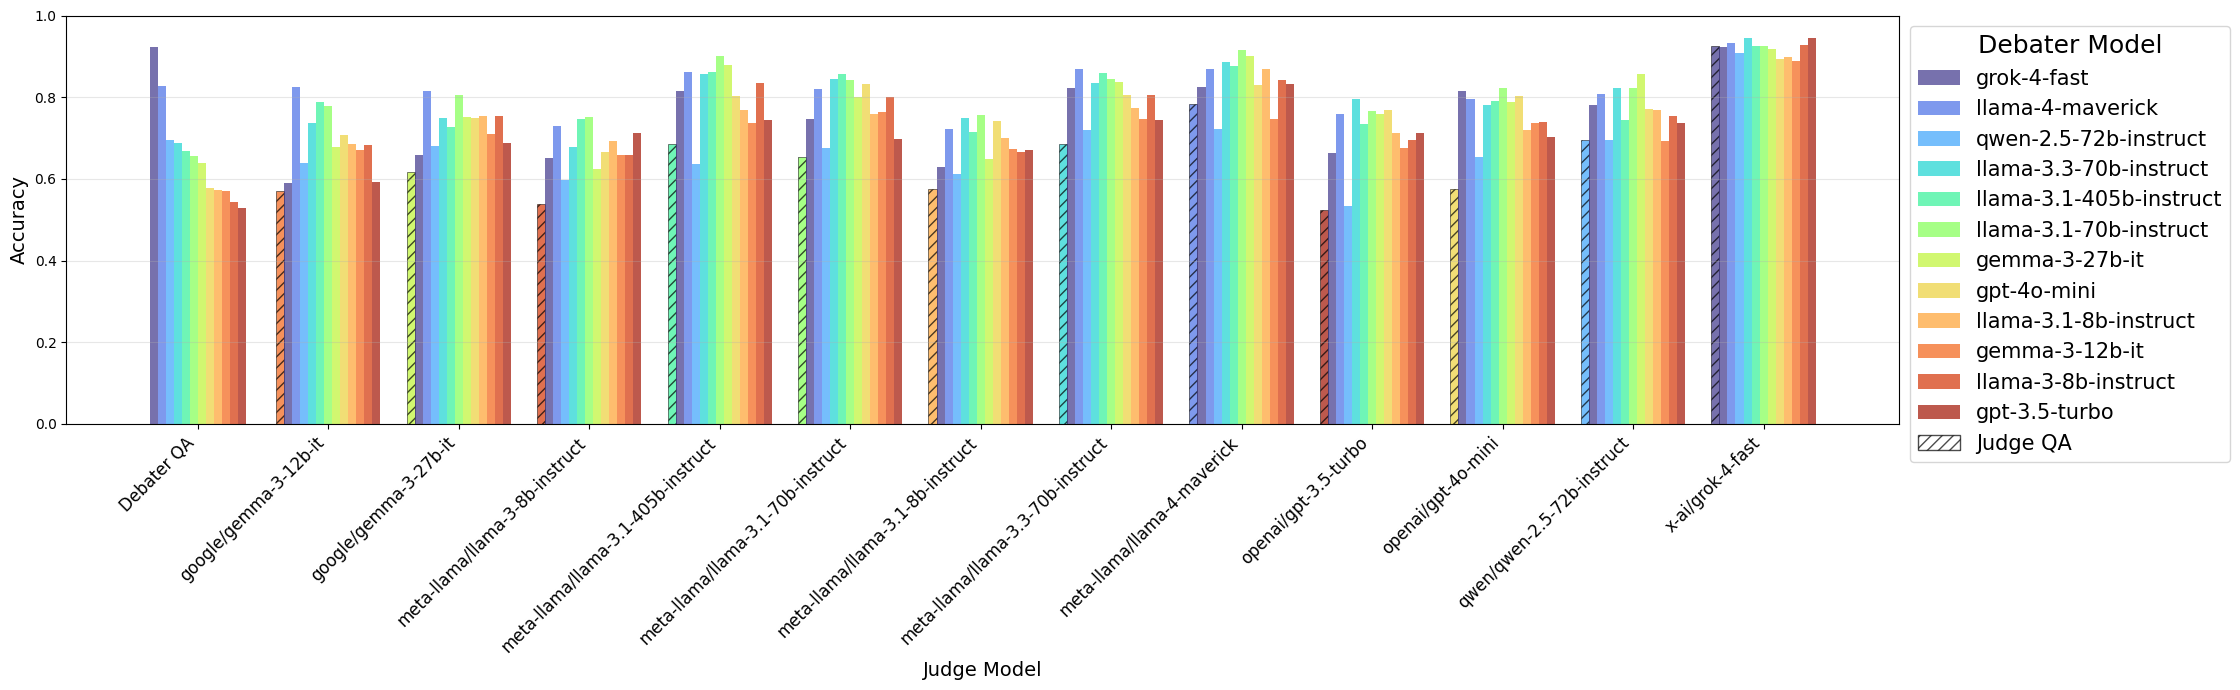

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

run_mapping = pd.DataFrame(data['runs'])
merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

# Build debate_run_id_labels from debate run configs
debate_run_id_labels = {}
for debate_run_id in merged['debate_run_id'].unique():
    with open(f"../results/debates/{debate_run_id}.jsonl", "r") as f:
        debate_record = json.loads(f.readline())
    debater_model = debate_record['config']['debater_model']
    model_short = debater_model.split('/')[-1] if '/' in debater_model else debater_model
    debate_run_id_labels[debate_run_id] = model_short

for run_idx in [0]:
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    judge_models = sorted(plot_data['model'].unique())
    
    # Sort debate runs by debater QA accuracy (highest to lowest)
    debater_scores = plot_data.groupby('debate_run_id')['debater_qa_acc'].first().sort_values(ascending=False)
    debate_run_ids = debater_scores.index.tolist()
    
    n_judges = len(judge_models)
    n_debates = len(debate_run_ids)
    
    fig, ax = plt.subplots(figsize=(25, 7))
    
    colors = plt.cm.turbo(np.linspace(0.05, 0.95, n_debates))
    
    # print("Debug: Order of debate_run_ids and labels:")
    # for i, debate_run_id in enumerate(debate_run_ids):
    #     label = debate_run_id_labels.get(debate_run_id, debate_run_id)
    #     print(f"  {i}: {debate_run_id} -> {label}")
    
    group_width = 0.8
    width = group_width / (n_debates + 1)
    
    x_labels = ['Debater QA'] + judge_models
    x_positions = np.arange(len(x_labels))
    
    # Group 0: Debater QA bars (one per debate run)
    for i, debate_run_id in enumerate(debate_run_ids):
        row = plot_data[plot_data['debate_run_id'] == debate_run_id].iloc[0]
        debater_qa_acc = row['debater_qa_acc']
        offset = (i - n_debates / 2 + 0.5) * width
        ax.bar(0 + offset, debater_qa_acc, width, color=colors[i], alpha=0.7)
    
    # Create mapping from judge model to debate_run_id (and thus color)
    judge_to_debate_run = {}
    for _, row in plot_data[['model', 'debate_run_id']].drop_duplicates('model').iterrows():
        judge_model_key = row['model']
        for debate_idx, drid in enumerate(debate_run_ids):
            debate_row = plot_data[plot_data['debate_run_id'] == drid].iloc[0]
            debater_model = debate_run_id_labels.get(drid, '')
            judge_model_short = judge_model_key.split('/')[-1] if '/' in judge_model_key else judge_model_key
            if debater_model == judge_model_short:
                judge_to_debate_run[judge_model_key] = debate_idx
                break
    
    # Groups 1 to n_judges: Judge QA + Verdicts
    for judge_idx, judge_model in enumerate(judge_models):
        x_pos = judge_idx + 1
        
        # First bar: Judge QA with hatch pattern in debater color
        judge_row = plot_data[plot_data['model'] == judge_model].iloc[0]
        judge_qa_acc = judge_row['judge_qa_acc']
        offset = (0 - (n_debates + 1) / 2 + 0.5) * width
        judge_color_idx = judge_to_debate_run.get(judge_model, 0)
        ax.bar(x_pos + offset, judge_qa_acc, width, color=colors[judge_color_idx], alpha=0.7, hatch='///', edgecolor='black', linewidth=0.5)
        
        # Remaining bars: Verdicts for each debate run
        for i, debate_run_id in enumerate(debate_run_ids):
            row = plot_data[(plot_data['model'] == judge_model) & 
                           (plot_data['debate_run_id'] == debate_run_id)]
            if len(row) > 0:
                verdict_acc = row['verdict_acc'].values[0]
                offset = ((i + 1) - (n_debates + 1) / 2 + 0.5) * width
                ax.bar(x_pos + offset, verdict_acc, width, color=colors[i], alpha=0.7)
    
    ax.set_xlabel('Judge Model', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
    
    from matplotlib.patches import Patch
    
    legend_elements = []
    for i, debate_run_id in enumerate(debate_run_ids):
        label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)}"
        legend_elements.append(Patch(facecolor=colors[i], alpha=0.7, label=label))
    
    rainbow_color = plt.cm.turbo(0.5)
    legend_elements.append(Patch(facecolor=rainbow_color, alpha=0.7, hatch='///', edgecolor='black', label='Judge QA (color = judge model)'))
    
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title='Debater Model', fontsize=15, title_fontsize=18)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()